In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
url=f"https://raw.githubusercontent.com/AYRUS06/Edge_AI_based_precision_irrigation/refs/heads/main/output_data_with_ET0.csv"
df=pd.read_csv(url)
df.tail()
df.shape
df.head()

YEAR  MO  DY  T2M_MIN  T2M_MAX   RH2M  WS2M  ALLSKY_SFC_SW_DWN    ET0
0  2010   1   1    17.52    28.38  72.15  2.89             17.820  4.778
1  2010   1   2    15.41    28.93  66.76  2.69             19.080  5.200
2  2010   1   3    15.10    27.57  70.37  1.95             19.332  4.814
3  2010   1   4    14.46    29.65  64.02  1.83             20.304  5.326
4  2010   1   5    13.64    30.33  63.20  1.95             19.908  5.338

In [24]:
def remove_outliers_iqr(df, features):
    cleaned_df = df.copy()
    for feature in features:
        Q1 = cleaned_df[feature].quantile(0.25)
        Q3 = cleaned_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned_df = cleaned_df[(cleaned_df[feature] >= lower) & (cleaned_df[feature] <= upper)]
        print(f"Removed {len(df) - len(cleaned_df)} outliers from {feature}")
    return cleaned_df
features = ['T2M_MIN', 'T2M_MAX', 'RH2M', 'WS2M', 'ALLSKY_SFC_SW_DWN', 'ET0']
df_cleaned= remove_outliers_iqr(df, features)
df_cleaned.shape

Removed 122 outliers from T2M_MIN
Removed 124 outliers from T2M_MAX
Removed 125 outliers from RH2M
Removed 243 outliers from WS2M
Removed 298 outliers from ALLSKY_SFC_SW_DWN
Removed 311 outliers from ET0


(5258, 9)

In [25]:
!pip install -U ydata_profiling

import ydata_profiling
import pandas as pd # Import pandas for reading the CSV

# Load the data into a DataFrame named 'output_data_with_ET0'
output_data_with_ET0 = pd.read_csv(f'https://raw.githubusercontent.com/AYRUS06/Edge_AI_based_precision_irrigation/refs/heads/main/output_data_with_ET0.csv')

from ydata_profiling.utils.cache import cache_file

report = df_cleaned.profile_report(sort=None, html={"style": {"full_width": True}}, progress_bar=False)
report

profile_report = df_cleaned.profile_report(html={"style": {"full_width": True}})
profile_report.to_file("example.html")

profile_report = df_cleaned.profile_report(
    explorative=True, html={"style": {"full_width": True}})
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 76.05it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 78.05it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: >

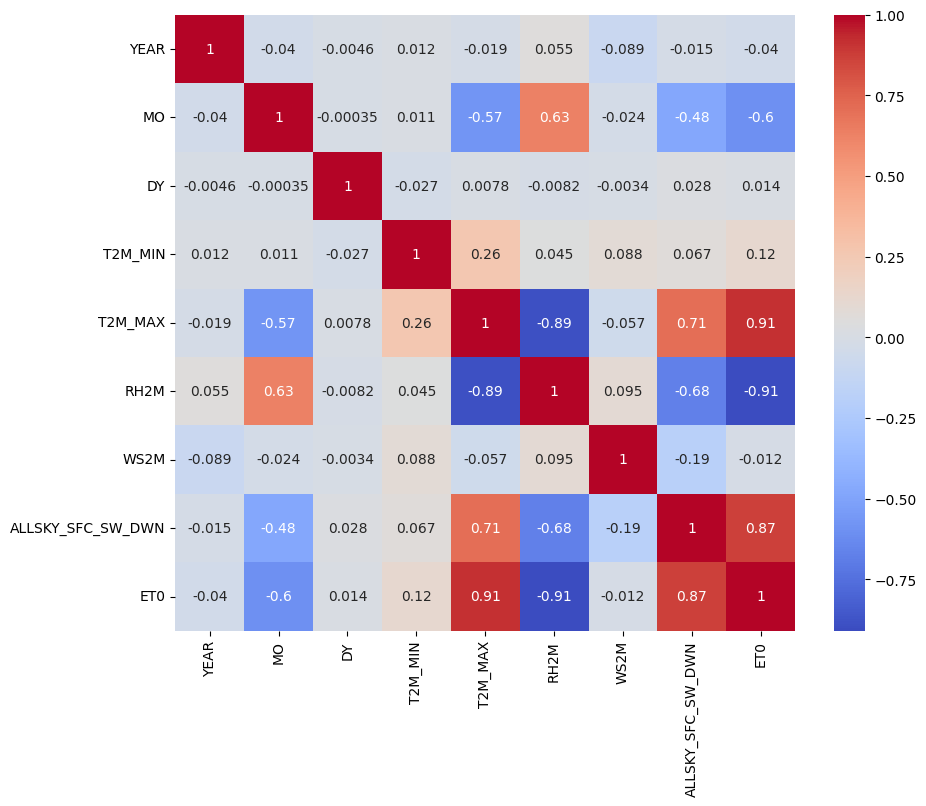

In [26]:
df_cleaned.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned.corr(), annot=True, cmap='coolwarm')

In [27]:
df_cleaned.drop(columns=['YEAR', 'DY', 'MO'], inplace=True)

In [28]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_scaled = scaler.fit_transform(df_cleaned)
# df_scaled = pd.DataFrame(df_scaled, columns=df_cleaned.columns)
# df_scaled.head()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cleaned)
df_scaled = pd.DataFrame(df_scaled, columns=df_cleaned.columns)
df_scaled.head()

T2M_MIN   T2M_MAX      RH2M      WS2M  ALLSKY_SFC_SW_DWN       ET0
0 -0.455899 -0.629694  0.287135  0.099587          -0.480752 -0.486189
1 -1.267821 -0.474509 -0.056696 -0.084756          -0.165699 -0.241519
2 -1.387109 -0.858239  0.173588 -0.766825          -0.102689 -0.465317
3 -1.633379 -0.271357 -0.231482 -0.877431           0.140352 -0.168466
4 -1.948913 -0.079492 -0.283790 -0.766825           0.041335 -0.161508

In [29]:
from sklearn.model_selection import train_test_split
X = df_scaled.drop(columns=['ET0'])
y = df_scaled['ET0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [31]:
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
y_pred_LR = model_LR.predict(X_test)
mse_LR = mean_squared_error(y_test, y_pred_LR)
r2_LR = r2_score(y_test, y_pred_LR)
print("Linear Regression MSE:", mse_LR)
print("Linear Regression R2:", r2_LR)

Linear Regression MSE: 0.019221886354103167
Linear Regression R2: 0.9801178170726929


In [32]:
best_features = ['T2M_MAX', 'RH2M', 'ALLSKY_SFC_SW_DWN']


In [33]:
df_new = df_scaled[best_features]
df_new['ET0'] = df_scaled['ET0']
df_new.head()

<ipython-input-33-629fe5febc3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['ET0'] = df_scaled['ET0']


T2M_MAX      RH2M  ALLSKY_SFC_SW_DWN       ET0
0 -0.629694  0.287135          -0.480752 -0.486189
1 -0.474509 -0.056696          -0.165699 -0.241519
2 -0.858239  0.173588          -0.102689 -0.465317
3 -0.271357 -0.231482           0.140352 -0.168466
4 -0.079492 -0.283790           0.041335 -0.161508

In [34]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df_new.drop(columns=['ET0']), df_new['ET0'], test_size=0.2, random_state=42)

In [35]:
model_LR1 = LinearRegression()
model_LR.fit(X_train1, y_train1)
y_pred_LR = model_LR.predict(X_test1)
mse_LR = mean_squared_error(y_test1, y_pred_LR)
r2_LR = r2_score(y_test1, y_pred_LR)
print("Linear Regression MSE:", mse_LR)
print("Linear Regression R2:", r2_LR)

Linear Regression MSE: 0.0369463661022275
Linear Regression R2: 0.9618963672174179


In [36]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

Model1_SVR_df_new = SVR()
Model1_SVR_df_new.fit(X_train1, y_train1)
y_pred_SVR = Model1_SVR_df_new.predict(X_test1)
mse_SVR = mean_squared_error(y_test1, y_pred_SVR)
r2_SVR = r2_score(y_test1, y_pred_SVR)
print("Support Vector Regressor MSE:", mse_SVR)
print("Support Vector Regressor R2:", r2_SVR)

Support Vector Regressor MSE: 0.031656185785660554
Support Vector Regressor R2: 0.9673522512298908


--- Raw Data Head ---
   YEAR  MO  DY  T2M_MIN  T2M_MAX   RH2M  WS2M  ALLSKY_SFC_SW_DWN    ET0
0  2010   1   1    17.52    28.38  72.15  2.89             17.820  4.778
1  2010   1   2    15.41    28.93  66.76  2.69             19.080  5.200
2  2010   1   3    15.10    27.57  70.37  1.95             19.332  4.814
3  2010   1   4    14.46    29.65  64.02  1.83             20.304  5.326
4  2010   1   5    13.64    30.33  63.20  1.95             19.908  5.338

--- Raw Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   YEAR               5569 non-null   int64  
 1   MO                 5569 non-null   int64  
 2   DY                 5569 non-null   int64  
 3   T2M_MIN            5569 non-null   float64
 4   T2M_MAX            5569 non-null   float64
 5   RH2M               5569 non-null   float64
 6   WS2M               556

<ipython-input-37-0a799d616fd7>:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mse_sorted.index, y='MSE', data=mse_sorted, ax=axes[0], palette='viridis')
<ipython-input-37-0a799d616fd7>:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=r2_sorted.index, y='R2', data=r2_sorted, ax=axes[1], palette='viridis')


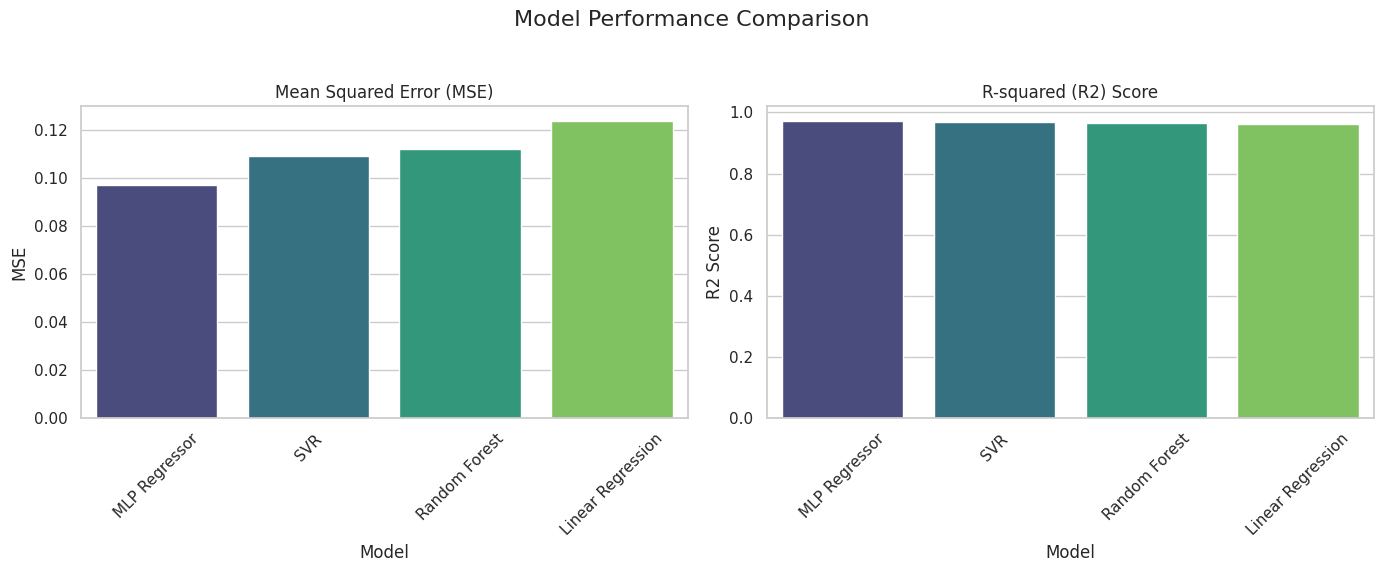

--- Finished ---


In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler # Import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
# Load data from the CSV file
try:
    # === MODIFICATION START ===
    # Load the dataset from the specified CSV file
    df = pd.read_csv('https://raw.githubusercontent.com/AYRUS06/Edge_AI_based_precision_irrigation/refs/heads/main/output_data_with_ET0.csv')
    # === MODIFICATION END ===

    # Display the first few rows and info to understand the structure
    print("--- Raw Data Head ---")
    print(df.head())
    print("\n--- Raw Data Info ---")
    df.info()
    print("\n")

    # Select best features and the target variable
    # Ensure these column names exactly match your CSV file
    best_features = ['T2M_MAX', 'RH2M', 'ALLSKY_SFC_SW_DWN']
    target_variable = 'ET0'

    # Check if all required columns exist
    required_columns = best_features + [target_variable]
    if not all(col in df.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in df.columns]
        raise ValueError(f"Missing required columns in CSV: {missing_cols}")

    # Create the feature DataFrame and the target Series
    X = df[best_features].copy()
    y = df[target_variable].copy()

    # --- Feature Scaling ---
    # Scaling is crucial for SVR and MLP, and doesn't hurt others
    print("--- Scaling Features ---")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Convert scaled features back to a DataFrame for consistency (optional, but can be helpful)
    X = pd.DataFrame(X_scaled, columns=best_features, index=X.index)
    print("Features scaled using StandardScaler.\n")


    # Split data into training and testing sets using the scaled features
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Training set size: {X_train1.shape[0]} samples")
    print(f"Test set size: {X_test1.shape[0]} samples")
    print("\n")

    # --- Model Training and Evaluation ---

    results = {}

    # 1. Linear Regression
    print("--- Training Linear Regression ---")
    model_LR = LinearRegression()
    model_LR.fit(X_train1, y_train1)
    y_pred_LR = model_LR.predict(X_test1)
    mse_LR = mean_squared_error(y_test1, y_pred_LR)
    r2_LR = r2_score(y_test1, y_pred_LR)
    results['Linear Regression'] = {'MSE': mse_LR, 'R2': r2_LR}
    print(f"Linear Regression MSE: {mse_LR:.4f}")
    print(f"Linear Regression R2: {r2_LR:.4f}\n")

    # 2. Support Vector Regressor (SVR)
    print("--- Training Support Vector Regressor (SVR) ---")
    model_SVR = SVR() # Using default parameters, consider tuning C, gamma, epsilon
    model_SVR.fit(X_train1, y_train1)
    y_pred_SVR = model_SVR.predict(X_test1)
    mse_SVR = mean_squared_error(y_test1, y_pred_SVR)
    r2_SVR = r2_score(y_test1, y_pred_SVR)
    results['SVR'] = {'MSE': mse_SVR, 'R2': r2_SVR}
    print(f"Support Vector Regressor MSE: {mse_SVR:.4f}")
    print(f"Support Vector Regressor R2: {r2_SVR:.4f}\n")

    # 3. Random Forest Regressor
    print("--- Training Random Forest Regressor ---")
    model_RF = RandomForestRegressor(n_estimators=100, random_state=42) # Consider tuning n_estimators, max_depth, etc.
    model_RF.fit(X_train1, y_train1)
    y_pred_RF = model_RF.predict(X_test1)
    mse_RF = mean_squared_error(y_test1, y_pred_RF)
    r2_RF = r2_score(y_test1, y_pred_RF)
    results['Random Forest'] = {'MSE': mse_RF, 'R2': r2_RF}
    print(f"Random Forest Regressor MSE: {mse_RF:.4f}")
    print(f"Random Forest Regressor R2: {r2_RF:.4f}\n")

    # 4. MLP Regressor
    print("--- Training MLP Regressor ---")
    # Consider tuning hidden_layer_sizes, activation, solver, alpha, learning_rate
    model_MLP = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42, early_stopping=True, n_iter_no_change=10)
    model_MLP.fit(X_train1, y_train1)
    y_pred_MLP = model_MLP.predict(X_test1)
    mse_MLP = mean_squared_error(y_test1, y_pred_MLP)
    r2_MLP = r2_score(y_test1, y_pred_MLP)
    results['MLP Regressor'] = {'MSE': mse_MLP, 'R2': r2_MLP}
    print(f"MLP Regressor MSE: {mse_MLP:.4f}")
    print(f"MLP Regressor R2: {r2_MLP:.4f}\n")

    # --- Model Comparison ---
    print("--- Model Comparison Results ---")
    results_df = pd.DataFrame(results).T # Transpose for better readability
    print(results_df)
    print("\n")

    # --- Visualization ---
    print("--- Generating Comparison Plots ---")

    # Set plot style
    sns.set(style="whitegrid")

    # Create figure and axes for subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Model Performance Comparison', fontsize=16)

    # Bar plot for MSE (Lower is better)
    # Order bars from lowest MSE to highest
    mse_sorted = results_df.sort_values('MSE')
    sns.barplot(x=mse_sorted.index, y='MSE', data=mse_sorted, ax=axes[0], palette='viridis')
    axes[0].set_title('Mean Squared Error (MSE)')
    axes[0].set_ylabel('MSE')
    axes[0].set_xlabel('Model')
    axes[0].tick_params(axis='x', rotation=45)

    # Bar plot for R2 Score (Higher is better)
    # Order bars from highest R2 to lowest
    r2_sorted = results_df.sort_values('R2', ascending=False)
    sns.barplot(x=r2_sorted.index, y='R2', data=r2_sorted, ax=axes[1], palette='viridis')
    axes[1].set_title('R-squared (R2) Score')
    axes[1].set_ylabel('R2 Score')
    axes[1].set_xlabel('Model')
    axes[1].tick_params(axis='x', rotation=45)
    # Add a horizontal line at R2=0 for reference
    axes[1].axhline(0, color='grey', lw=1, linestyle='--')


    # Adjust layout and display plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

except FileNotFoundError:
    print(f"Error: The file 'output_data_with_ET0.csv' was not found.")
    print("Please ensure the CSV file is in the same directory as the script or provide the correct path.")
except ValueError as ve:
    print(f"Data Error: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


print("--- Finished ---")


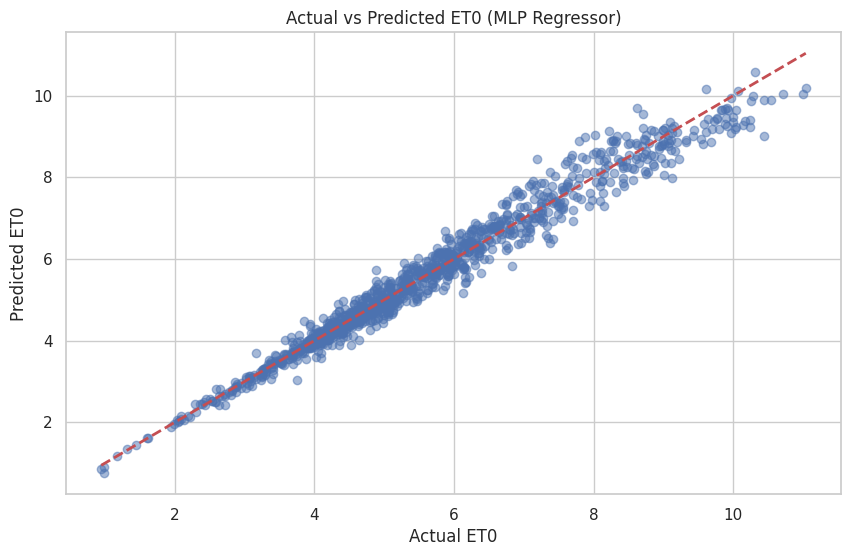

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test1, y_pred_MLP, alpha=0.5)
plt.plot([y_test1.min(), y_test1.max()], [y_test1.min(), y_test1.max()], 'r--', lw=2)
plt.xlabel('Actual ET0')
plt.ylabel('Predicted ET0')
plt.title('Actual vs Predicted ET0 (MLP Regressor)')
plt.show()

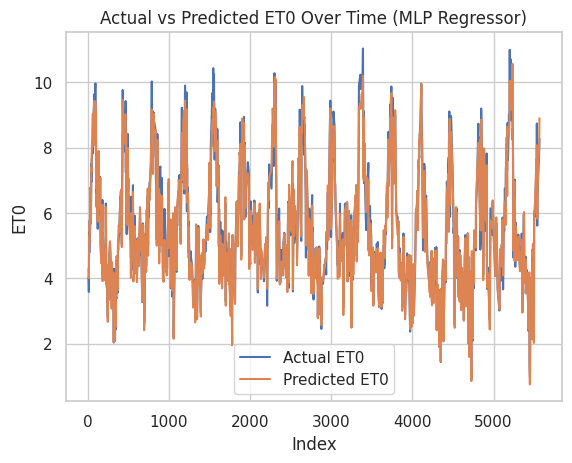

In [39]:
sns.lineplot(x=y_test1.index, y=y_test1, label='Actual ET0')
sns.lineplot(x=y_test1.index, y=y_pred_MLP, label='Predicted ET0')
plt.xlabel('Index')
plt.ylabel('ET0')
plt.title('Actual vs Predicted ET0 Over Time (MLP Regressor)')
plt.legend()
plt.show()

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress ConvergenceWarning for cleaner output during extraction focus
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Configuration ---
CSV_FILE = 'https://raw.githubusercontent.com/AYRUS06/Edge_AI_based_precision_irrigation/refs/heads/main/output_data_with_ET0.csv'
BEST_FEATURES = ['T2M_MAX', 'RH2M', 'ALLSKY_SFC_SW_DWN']
TARGET_VARIABLE = 'ET0'
TEST_SIZE = 0.2
RANDOM_STATE = 42
# MLP Parameters (Keep it relatively simple for Pico)
# You might need to experiment with smaller layers if memory is still an issue
HIDDEN_LAYER_SIZES = (16, 8) # Reduced layers for Pico suitability
MAX_ITER = 1500 # Increased iterations might be needed for smaller networks
EARLY_STOPPING = True
N_ITER_NO_CHANGE = 15

# --- Data Preparation ---
print(f"--- Loading Data from {CSV_FILE} ---")
try:
    df = pd.read_csv(CSV_FILE)
    print("Data loaded successfully.")

    # Check for required columns
    required_columns = BEST_FEATURES + [TARGET_VARIABLE]
    if not all(col in df.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in df.columns]
        raise ValueError(f"Missing required columns in CSV: {missing_cols}")

    X = df[BEST_FEATURES].copy()
    y = df[TARGET_VARIABLE].copy()

    # Handle potential NaN values (replace with mean, or choose another strategy)
    if X.isnull().values.any():
        print("Warning: NaN values found in features. Filling with mean.")
        X = X.fillna(X.mean())
    if y.isnull().values.any():
        print("Warning: NaN values found in target. Filling with mean.")
        y = y.fillna(y.mean())


    # --- Feature Scaling ---
    print("--- Scaling Features ---")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("Features scaled using StandardScaler.")
    # Keep X_scaled as numpy array for training

    # --- Train/Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}\n")

    # --- Train MLP Regressor ---
    print(f"--- Training MLP Regressor {HIDDEN_LAYER_SIZES} ---")
    model_MLP = MLPRegressor(
        hidden_layer_sizes=HIDDEN_LAYER_SIZES,
        activation='relu', # Standard activation, easy to implement
        solver='adam',
        max_iter=MAX_ITER,
        random_state=RANDOM_STATE,
        early_stopping=EARLY_STOPPING,
        n_iter_no_change=N_ITER_NO_CHANGE,
        learning_rate_init=0.001 # Default, adjust if needed
    )
    model_MLP.fit(X_train, y_train)
    print("MLP Model training complete.")

    # --- Evaluate (Optional but recommended) ---
    from sklearn.metrics import mean_squared_error, r2_score
    y_pred_MLP = model_MLP.predict(X_test)
    mse_MLP = mean_squared_error(y_test, y_pred_MLP)
    r2_MLP = r2_score(y_test, y_pred_MLP)
    print(f"\n--- Model Evaluation ---")
    print(f"MLP Regressor MSE: {mse_MLP:.4f}")
    print(f"MLP Regressor R2: {r2_MLP:.4f}\n")


    # --- Extract Parameters ---
    print("--- Extracting Model Parameters for MicroPython ---")

    # 1. Scaler Parameters
    scaler_mean = scaler.mean_.tolist()
    scaler_scale = scaler.scale_.tolist() # Use scale_ (standard deviation)

    # 2. MLP Weights and Biases
    # Coefs are weights, Intercepts are biases
    weights = [coef.tolist() for coef in model_MLP.coefs_]
    biases = [intercept.tolist() for intercept in model_MLP.intercepts_]

    # --- Print Parameters in MicroPython Format ---
    # Clear instructions for the user
    print("\n" + "="*50)
    print("COPY THE FOLLOWING PARAMETERS INTO YOUR MicroPython SCRIPT")
    print("="*50 + "\n")

    print("# --- Scaler Parameters ---")
    print(f"SCALER_MEAN = {scaler_mean}")
    print(f"SCALER_SCALE = {scaler_scale}\n")

    print("# --- MLP Parameters ---")
    # Print weights layer by layer
    for i, w in enumerate(weights):
        print(f"# Weights: Layer {i} (Input/Previous Layer -> Layer {i+1})")
        print(f"WEIGHTS_{i} = [")
        for row in w:
            print(f"    {row},")
        print("]\n")

    # Print biases layer by layer
    for i, b in enumerate(biases):
        print(f"# Biases: Layer {i+1}")
        print(f"BIASES_{i} = {b}\n")

    print("="*50)
    print("PARAMETER EXTRACTION COMPLETE")
    print("="*50)


except FileNotFoundError:
    print(f"Error: The file '{CSV_FILE}' was not found.")
except ValueError as ve:
    print(f"Data Error: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")



--- Loading Data from https://raw.githubusercontent.com/AYRUS06/Edge_AI_based_precision_irrigation/refs/heads/main/output_data_with_ET0.csv ---
Data loaded successfully.
--- Scaling Features ---
Features scaled using StandardScaler.
Training set size: 4455, Test set size: 1114

--- Training MLP Regressor (16, 8) ---
MLP Model training complete.

--- Model Evaluation ---
MLP Regressor MSE: 0.0955
MLP Regressor R2: 0.9716

--- Extracting Model Parameters for MicroPython ---

COPY THE FOLLOWING PARAMETERS INTO YOUR MicroPython SCRIPT

# --- Scaler Parameters ---
SCALER_MEAN = [30.523708026575687, 67.71459507990662, 18.924402944873407]
SCALER_SCALE = [3.5751311909811117, 15.723214825593704, 48.63370888697871]

# --- MLP Parameters ---
# Weights: Layer 0 (Input/Previous Layer -> Layer 1)
WEIGHTS_0 = [
    [0.053256736082930384, 0.4556614644198747, 0.2956831098132046, 0.390611203857762, -0.49573082787825595, -0.26712442338928777, -0.4410235572435593, 0.3151124934653342, -2.0374896975933982e-